In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_percentage_error

import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

In [2]:
plt.style.use("bmh")

# Setup
## Get Data

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col = 'id')

In [4]:
print(train.shape)
train.describe().style.background_gradient('Reds')

(7340, 17)


,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7070.000000,7070.000000,7340.000000,7340.000000
mean,5535.443869,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335
std,2182.680279,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.542875,1.546102,784.167637,8934.848328
min,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000
25%,4434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000
50%,5370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000
75%,7009.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2308.000000,30028.750000
max,18139.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000


In [5]:
print(test.shape)
test.describe().style.background_gradient('Reds')

(397, 7)


,holiday,shops_closed,winter_school_holidays,school_holidays
count,397.000000,397.000000,397.000000,397.000000
mean,0.068010,0.020151,0.020151,0.070529
std,0.252081,0.140694,0.140694,0.256359
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Missing Values

In [6]:
table = PrettyTable()
missings = ['orders', 'shutdown', 'mini_shutdown', 'blackout', 'mov_change', 'frankfurt_shutdown', 
            'precipitation', 'snow', 'user_activity_1', 'user_activity_2']
table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %']
for column in train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train= np.round(100-train[column].count()/train.shape[0]*100,1)
    if column not in missings:
        non_null_count_test = np.round(100-test[column].count()/test.shape[0]*100,1)
    else:
        non_null_count_test="Not present"
    table.add_row([column, data_type, non_null_count_train,non_null_count_test])
print(table)

+------------------------+-----------+-----------------+----------------+
|        Feature         | Data Type | Train Missing % | Test Missing % |
+------------------------+-----------+-----------------+----------------+
|       warehouse        |   object  |       0.0       |      0.0       |
|          date          |   object  |       0.0       |      0.0       |
|         orders         |  float64  |       0.0       |  Not present   |
|      holiday_name      |   object  |       97.0      |      95.7      |
|        holiday         |   int64   |       0.0       |      0.0       |
|        shutdown        |   int64   |       0.0       |  Not present   |
|     mini_shutdown      |   int64   |       0.0       |  Not present   |
|      shops_closed      |   int64   |       0.0       |      0.0       |
| winter_school_holidays |   int64   |       0.0       |      0.0       |
|    school_holidays     |   int64   |       0.0       |      0.0       |
|        blackout        |   int64   |

# Preprocessing
Credit goes to [Sheikh Muhammad Abdullah](https://www.kaggle.com/abdmental01) in his [notebook](https://www.kaggle.com/code/abdmental01/rohlik-starter-v1) for the following function

In [7]:
train['holiday_name'] = train['holiday_name'].fillna('None')
test['holiday_name'] = test['holiday_name'].fillna('None')

In [8]:
# Dictionary mapping cities to their countries
city_to_country = {
    'Munich_1': 'Germany',
    'Frankfurt_1': 'Germany',
    'Budapest_1': 'Hungary',
    'Brno_1': 'Czech Republic',
    'Prague_1': 'Czech Republic',
    'Prague_2': 'Czech Republic',
    'Prague_3': 'Czech Republic'
}
train['country'] = train['warehouse'].map(city_to_country)
test['country'] = test['warehouse'].map(city_to_country)

In [9]:
def Process_Date(Df):

    Df['date'] = pd.to_datetime(Df['date'])

    Df['year'] = Df['date'].dt.year

    Df['day'] = Df['date'].dt.day

    Df['month'] = Df['date'].dt.month

    Df['month_name'] = Df['date'].dt.month_name()

    Df['day_of_week'] = Df['date'].dt.day_name()

    Df['week'] = Df['date'].dt.isocalendar().week
    
    Df['year_sin'] = np.sin(2 * np.pi * Df['year'])
    Df['year_cos'] = np.cos(2 * np.pi * Df['year'])
    Df['month_sin'] = np.sin(2 * np.pi * Df['month'] / 12) 
    Df['month_cos'] = np.cos(2 * np.pi * Df['month'] / 12)
    Df['day_sin'] = np.sin(2 * np.pi * Df['day'] / 31)  
    Df['day_cos'] = np.cos(2 * np.pi * Df['day'] / 31)
    Df['group']=(Df['year']-2020)*48+Df['month']*4+Df['day']//7
    
    Df['total_holidays_month'] = Df.groupby(['year', 'month'])['holiday'].transform('sum')
    Df['total_shops_closed_week'] = Df.groupby(['year', 'week'])['shops_closed'].transform('sum')

    Df['group_sin'] = np.sin(2 * np.pi * Df['group'] / Df['group'].max())
    Df['group_cos'] = np.cos(2 * np.pi * Df['group'] / Df['group'].max())


    return Df

In [10]:
train = Process_Date(train)
test = Process_Date(test)

In [11]:
# Use only columns we have also in test set
train = train[['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'day', 'month',
       'month_name', 'day_of_week', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'group',
       'total_holidays_month', 'total_shops_closed_week',
       'group_sin', 'group_cos', 'country',
       'orders']]

In [12]:
def apply_tfidf_svd(df, text_column, max_features=1000, n_components=10):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    vectors = vectorizer.fit_transform(df[text_column])
    svd = TruncatedSVD(n_components)
    x_sv = svd.fit_transform(vectors)
    tfidf_df = pd.DataFrame(x_sv)
    cols = [(text_column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis="columns")
    return df

In [13]:
train = apply_tfidf_svd(train,'holiday_name')
test = apply_tfidf_svd(test,'holiday_name')

In [14]:
train = train.drop(columns=['holiday_name'])
test = test.drop(columns=['holiday_name'])

In [15]:
# Convert some columns to categorical
categorical_columns = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
train[categorical_columns] = train[categorical_columns].astype('category')
test[categorical_columns] = test[categorical_columns].astype('category')

In [16]:
num_features = train._get_numeric_data().columns
cat_features = train.drop(num_features, axis=1).columns

# Exploratory Data Analysis
## Target Distribution

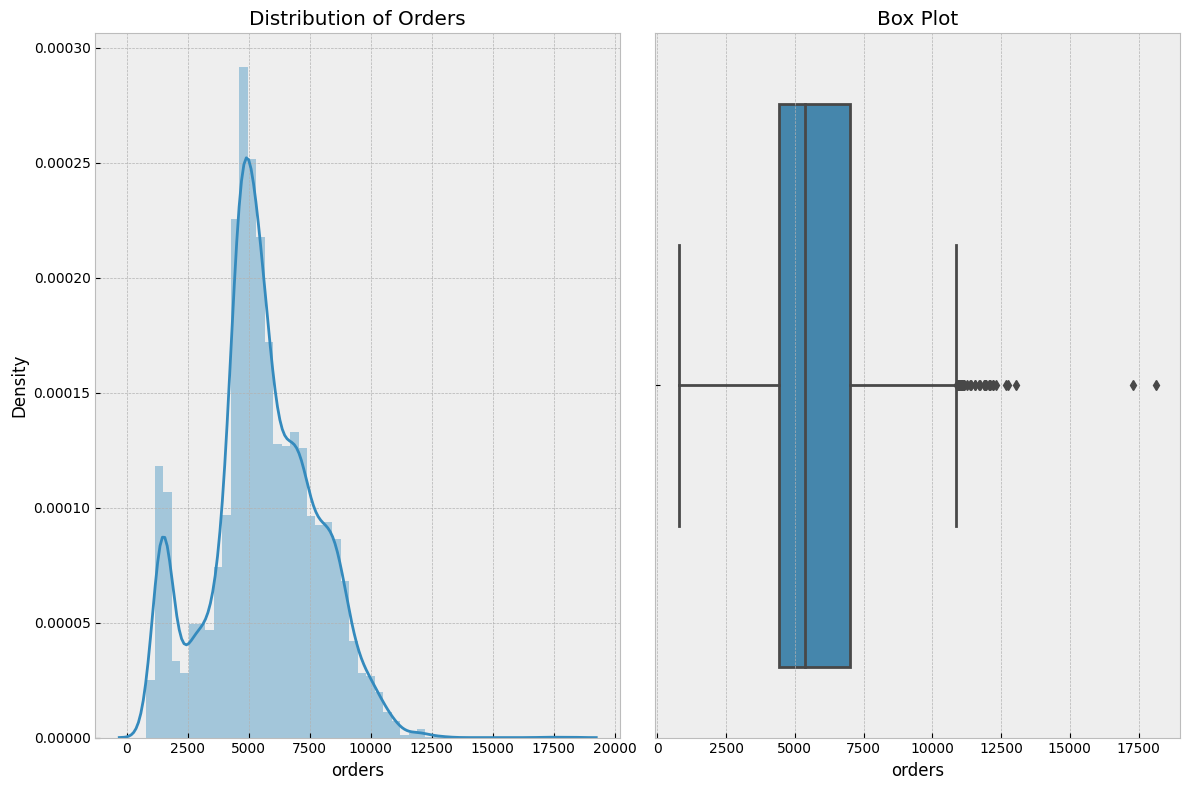

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
sns.distplot(train['orders'], ax=axs[0])
axs[0].set_title('Distribution of Orders')

sns.boxplot(x=train['orders'], ax=axs[1])
axs[1].set_title('Box Plot')

plt.tight_layout()
plt.show()

## Numeric Feature Distribution

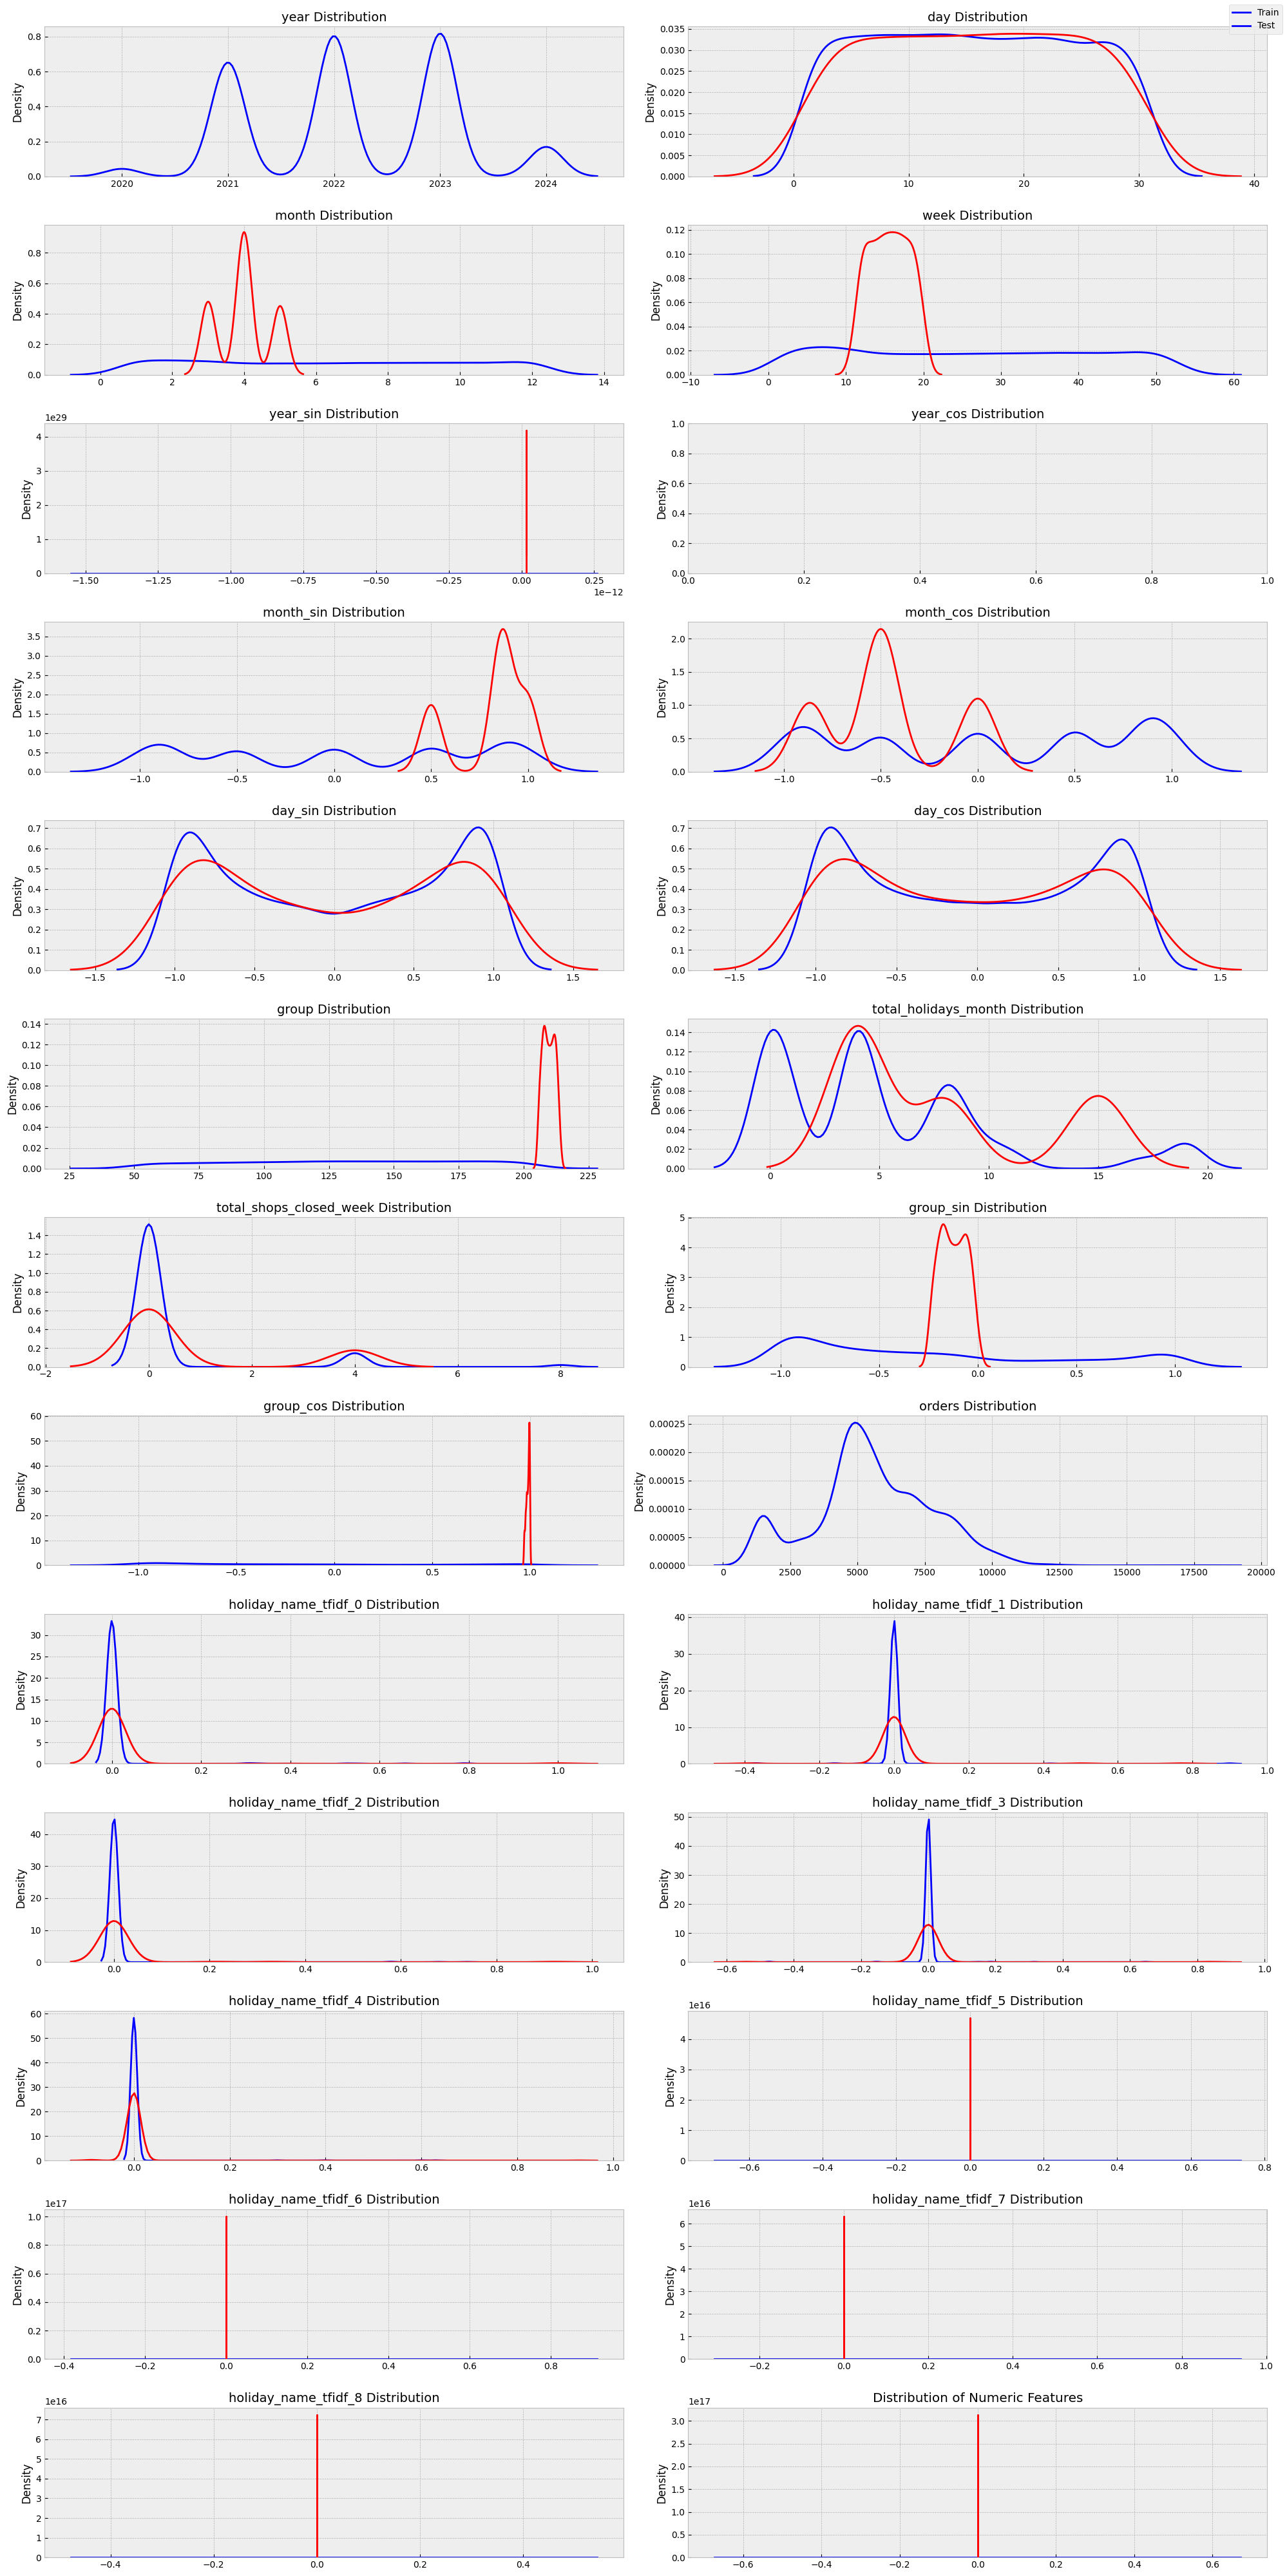

In [18]:
fig, ax = plt.subplots(13, 2, figsize=(20,40))
ax = ax.flatten()
for idx,column in enumerate(num_features):
    if column in train.columns:
        sns.kdeplot(data=train, x=column, ax=ax[idx], label='Train', color='blue')
    if column in test.columns:
        sns.kdeplot(data=test, x=column, ax=ax[idx], label='Test', color='red')
    
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
fig.legend(['Train', 'Test'])
plt.tight_layout()
plt.title('Distribution of Numeric Features')
plt.show();

## Categorical Feature Distribution

In [19]:
cat_cols_to_viz = list(cat_features)
cat_cols_to_viz.remove('date')

In [20]:
fig, ax = plt.subplots(9, 2, figsize=(20,50), dpi=300)
for idx, column in enumerate(cat_cols_to_viz):
        sns.countplot(data=train, y=column, ax=ax[idx][0], palette='rocket')
        sns.countplot(data=test, y=column, ax=ax[idx][1], palette='rocket')
plt.tight_layout(pad=3.0)
plt.show()

## Correlations

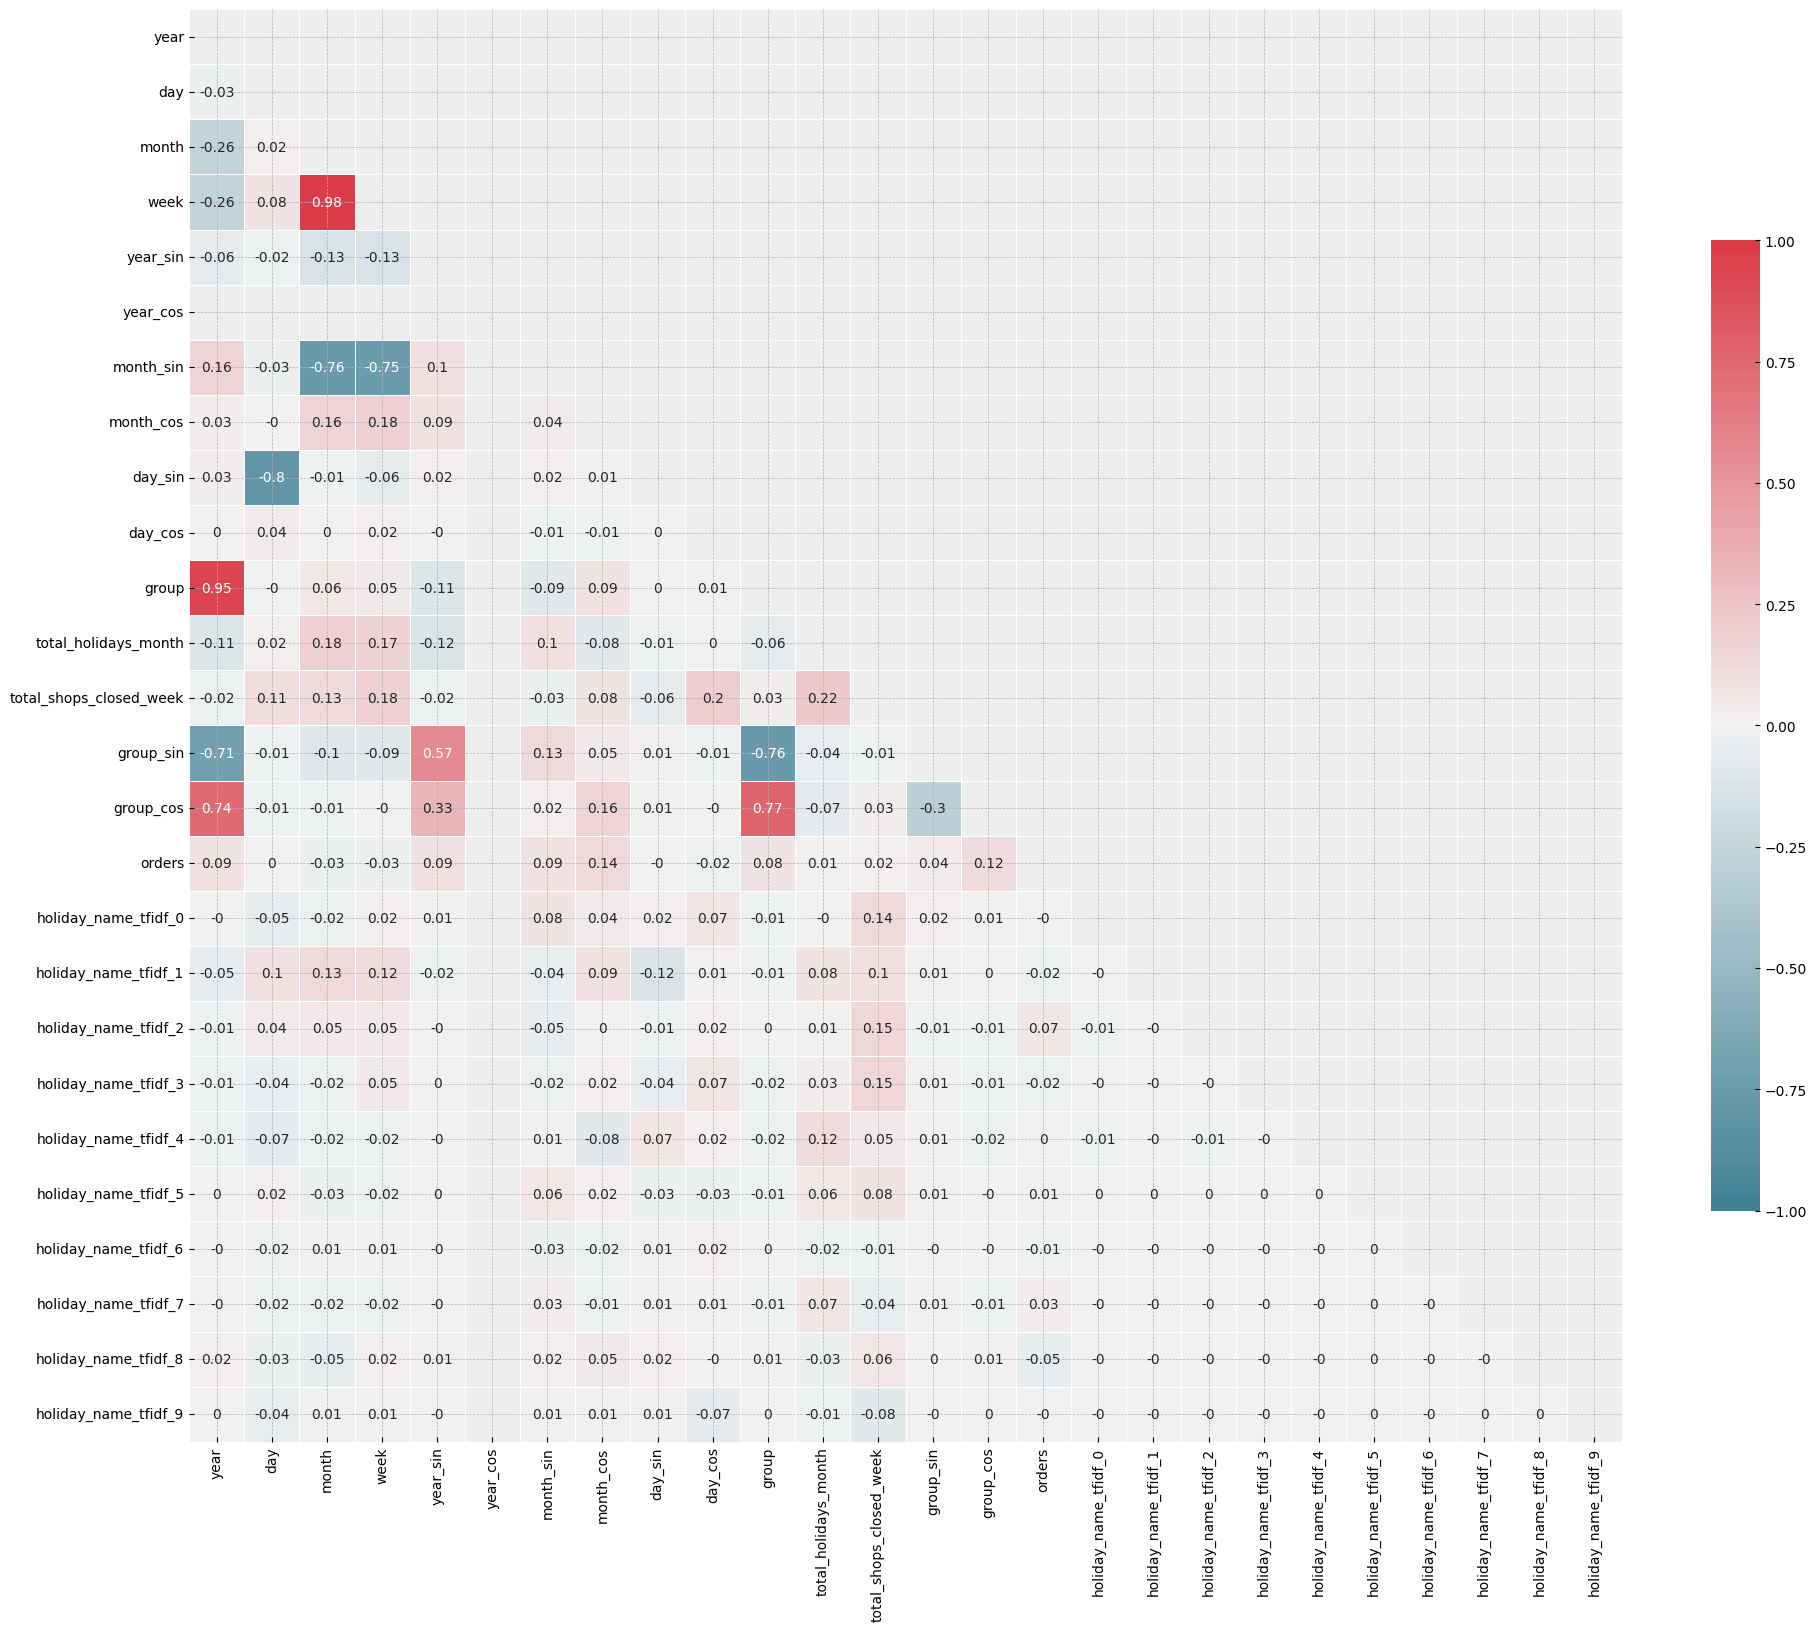

In [21]:
corr = train[num_features].corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

## Time Series Visualization

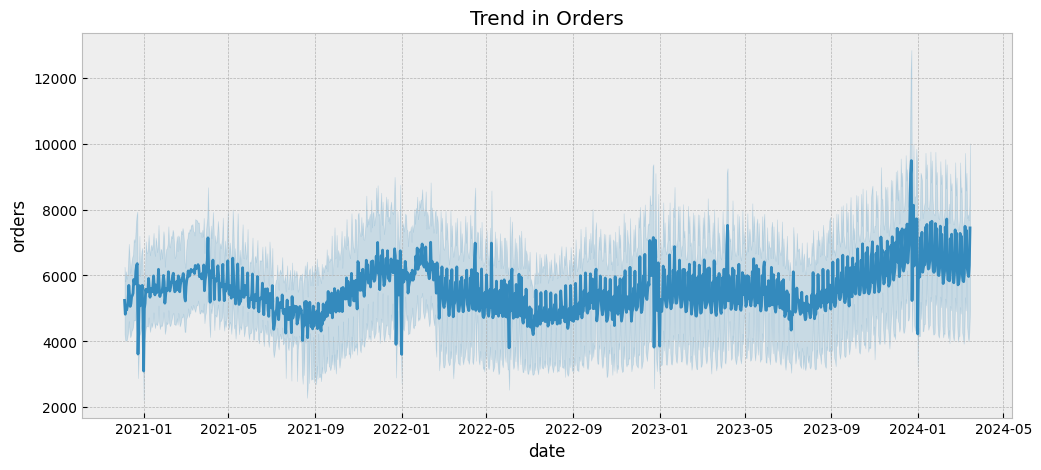

In [22]:
plt.figure(figsize=(12,5))
sns.lineplot(data=train, x='date', y='orders')
plt.title('Trend in Orders')
plt.show();

### Daily Distribution

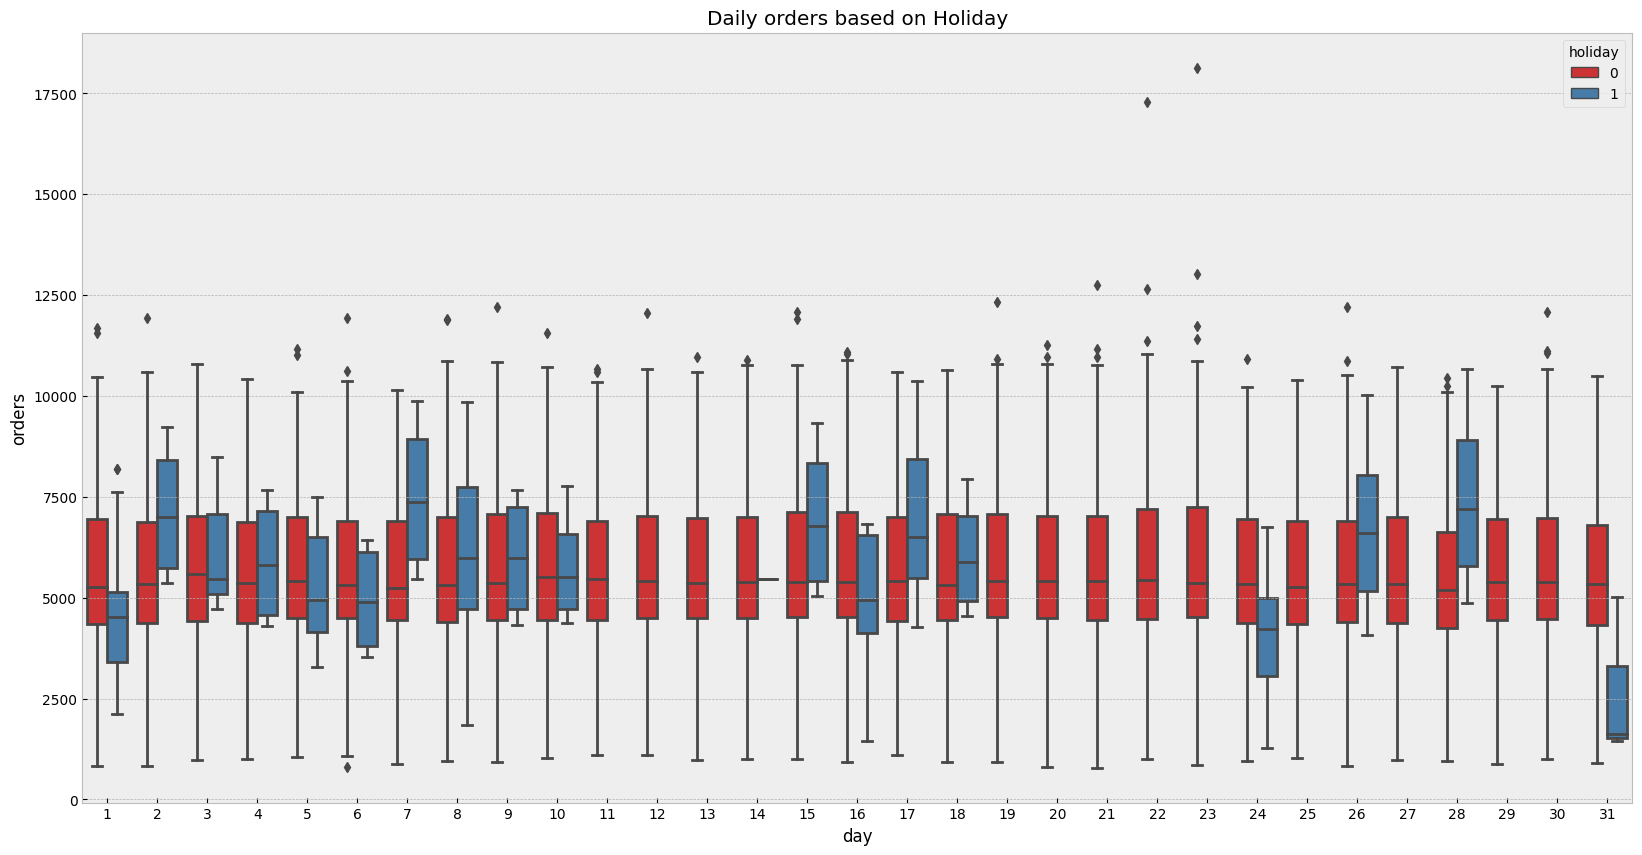

In [23]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='day', hue='holiday', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Daily orders based on Holiday')
plt.show()

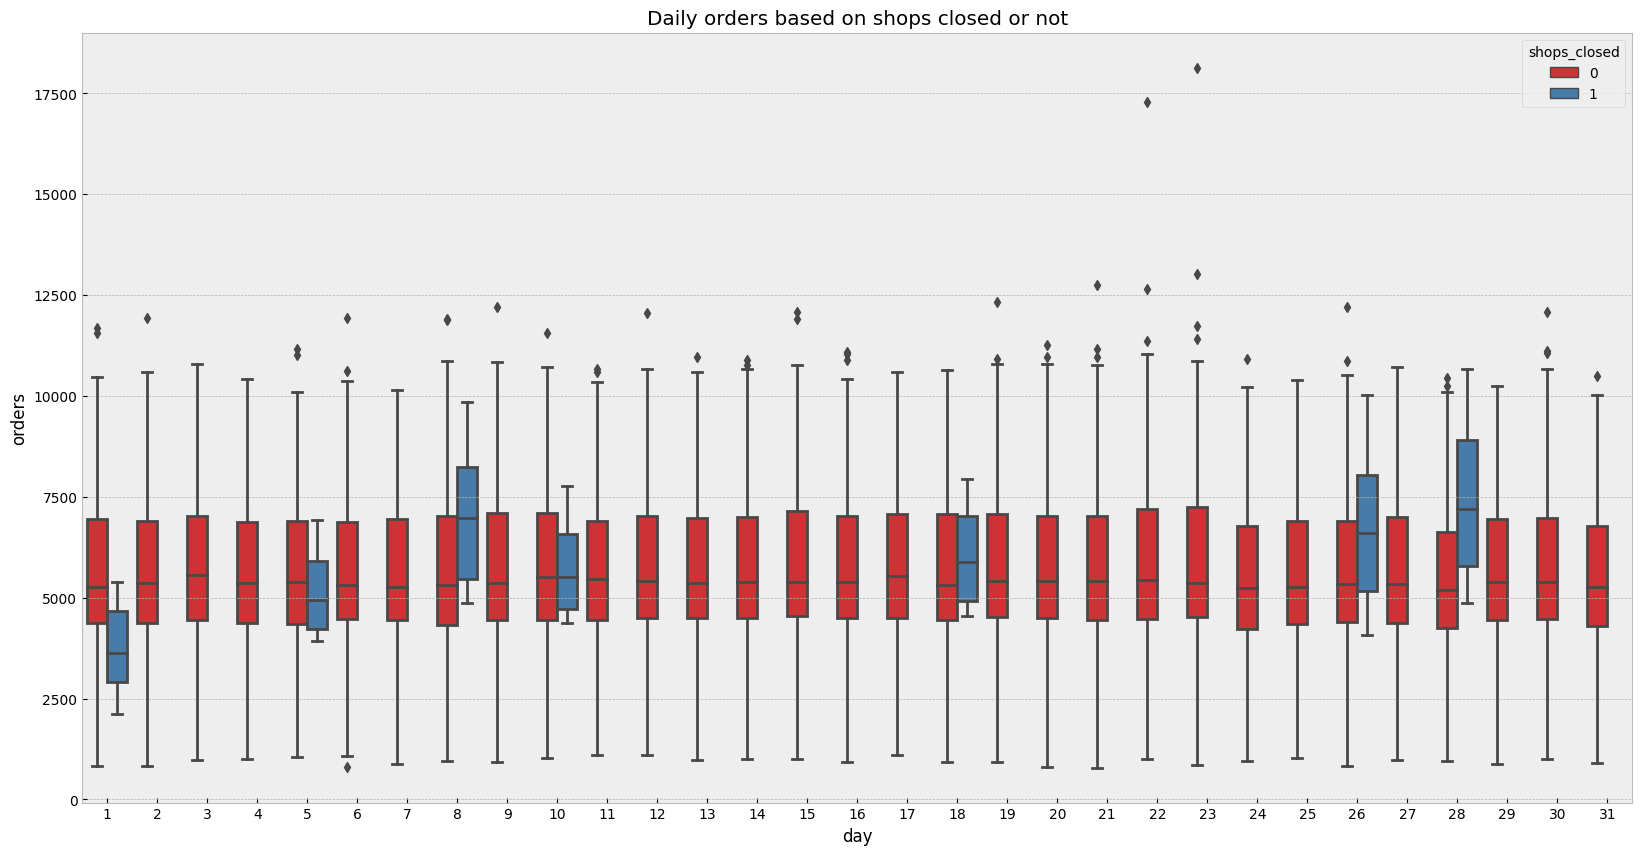

In [24]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='day', hue='shops_closed', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Daily orders based on shops closed or not')
plt.show()

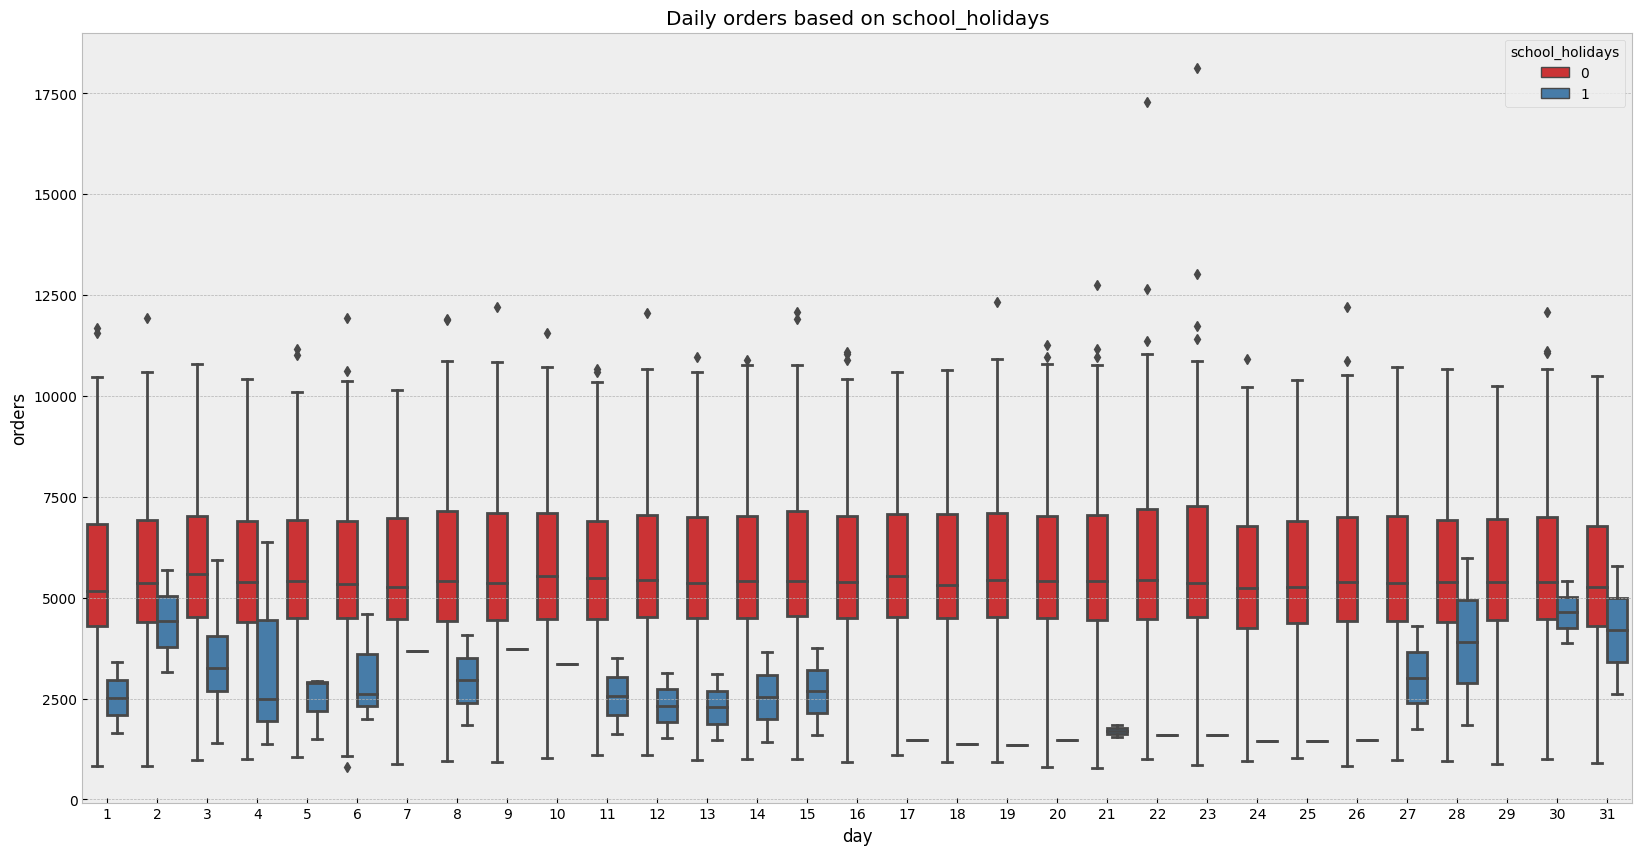

In [25]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='day', hue='school_holidays', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Daily orders based on school_holidays')
plt.show()

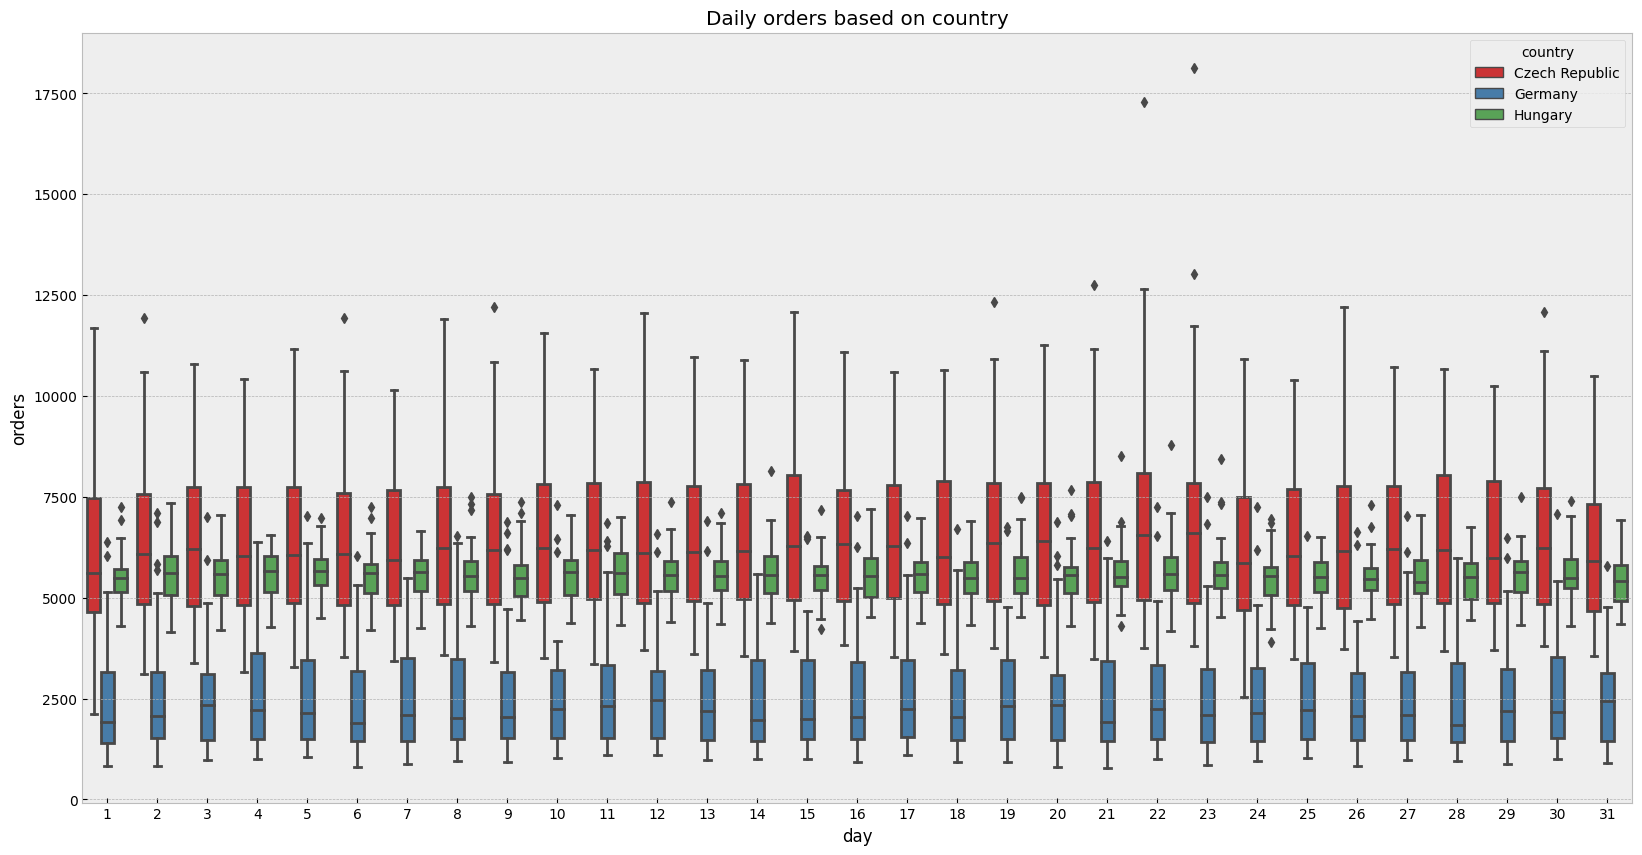

In [26]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='day', hue='country', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Daily orders based on country')
plt.show()

### Monthly Distribution

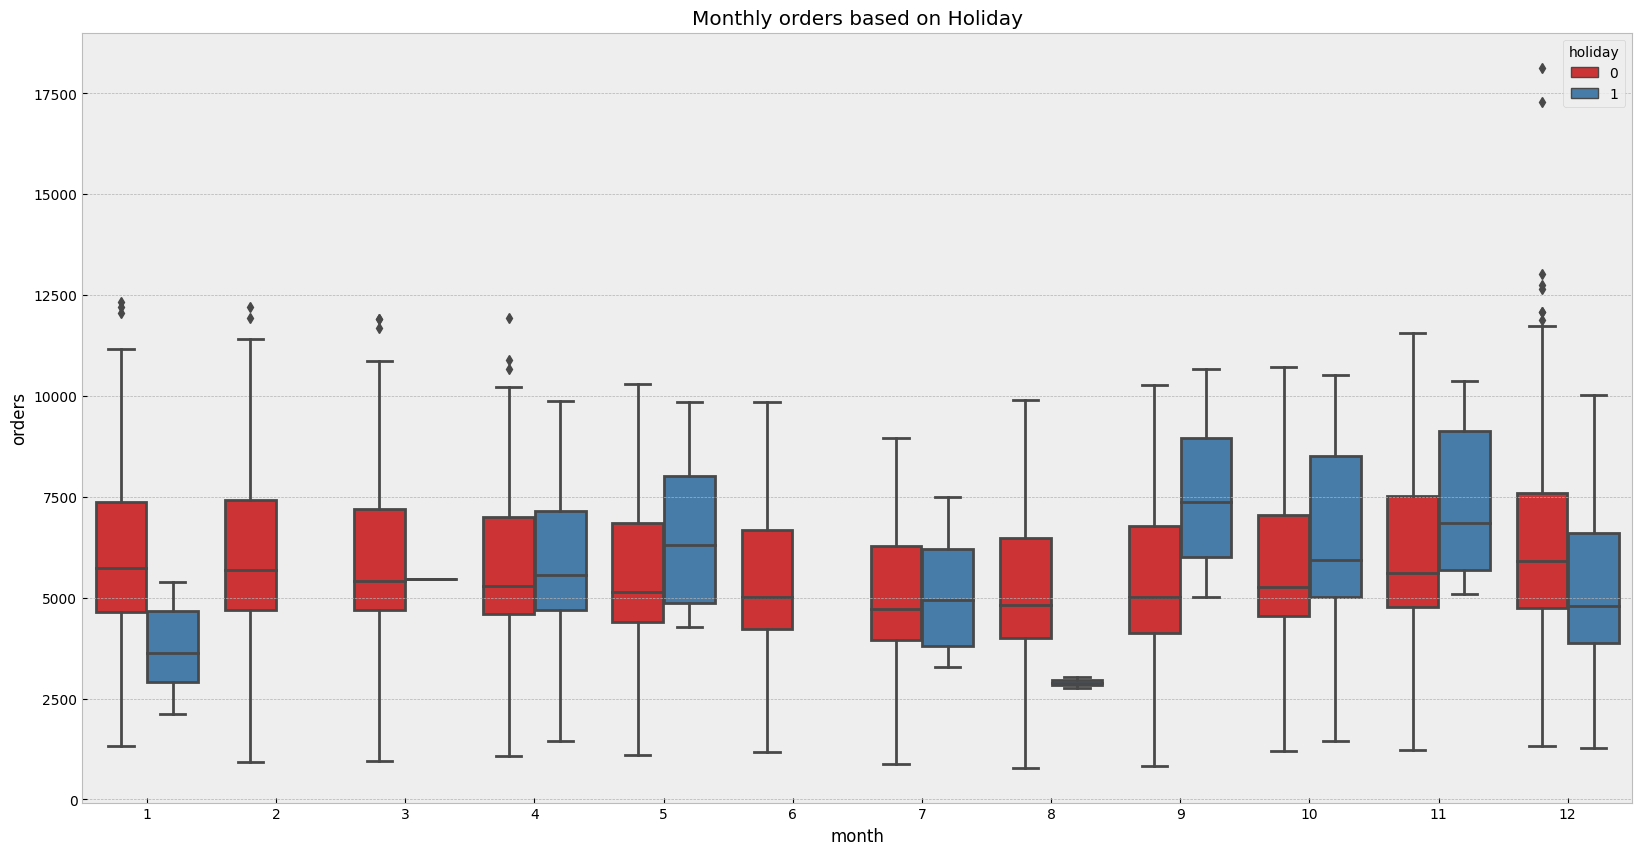

In [27]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='month', hue='holiday', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Monthly orders based on Holiday')
plt.show()

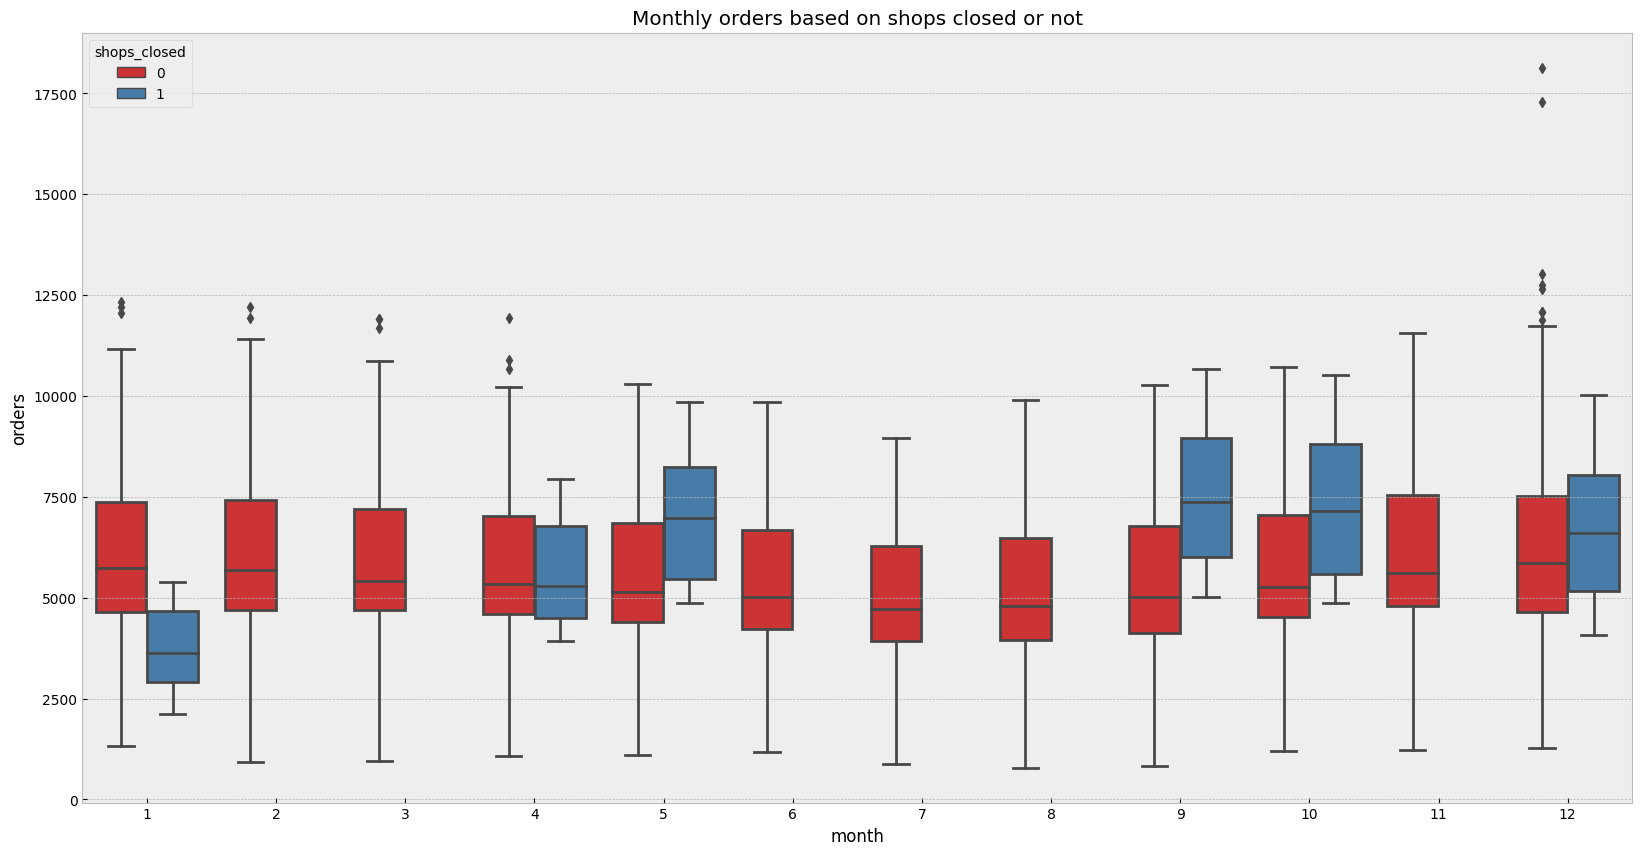

In [28]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='month', hue='shops_closed', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Monthly orders based on shops closed or not')
plt.show()

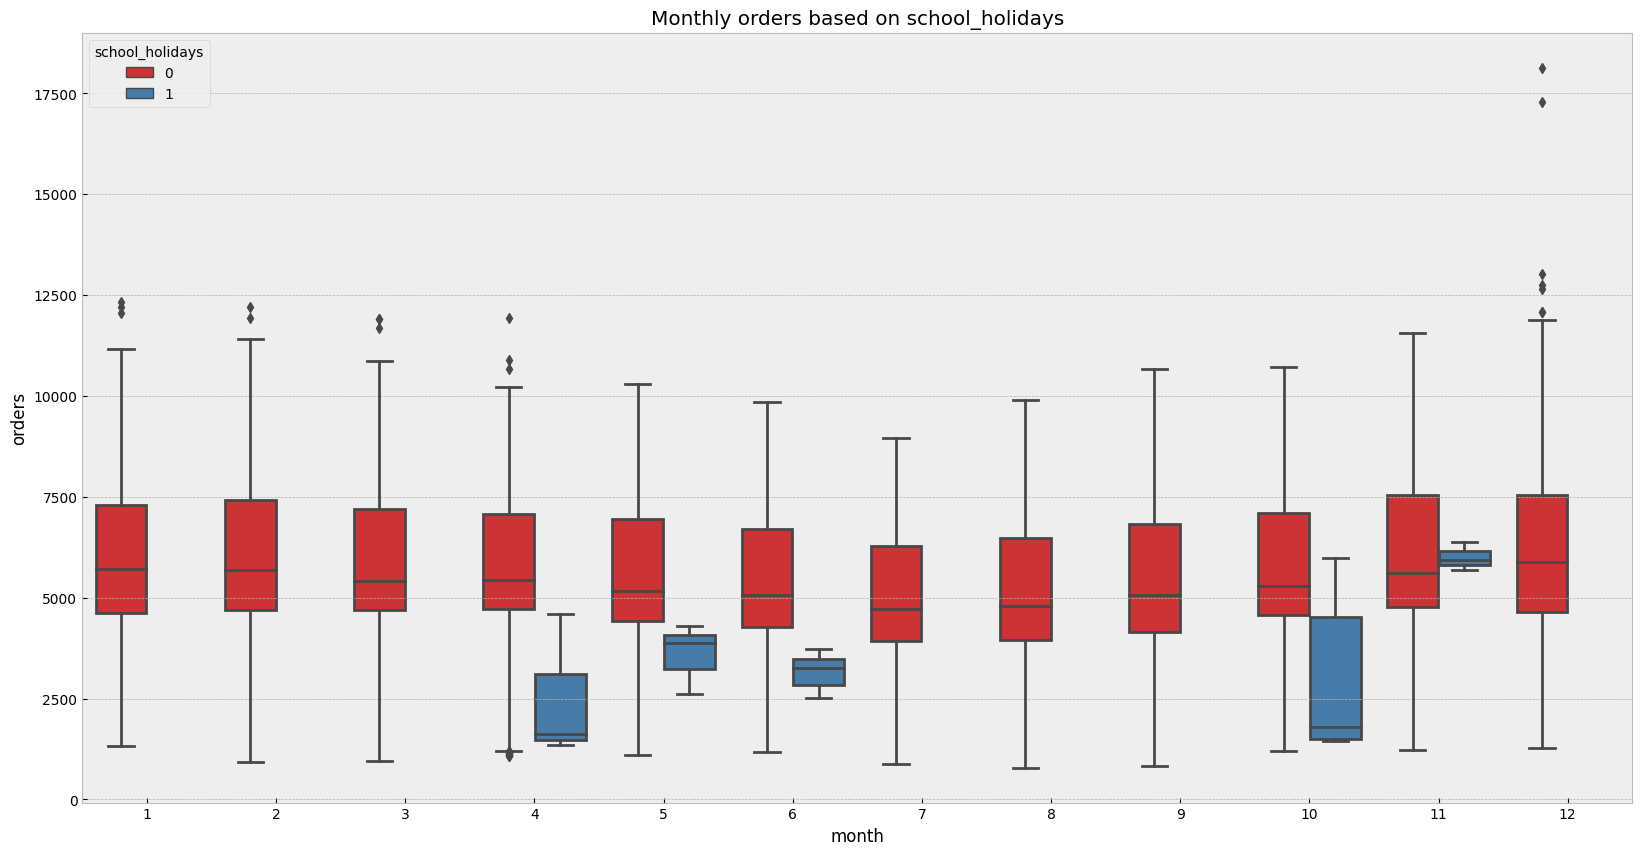

In [29]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='month', hue='school_holidays', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Monthly orders based on school_holidays')
plt.show()

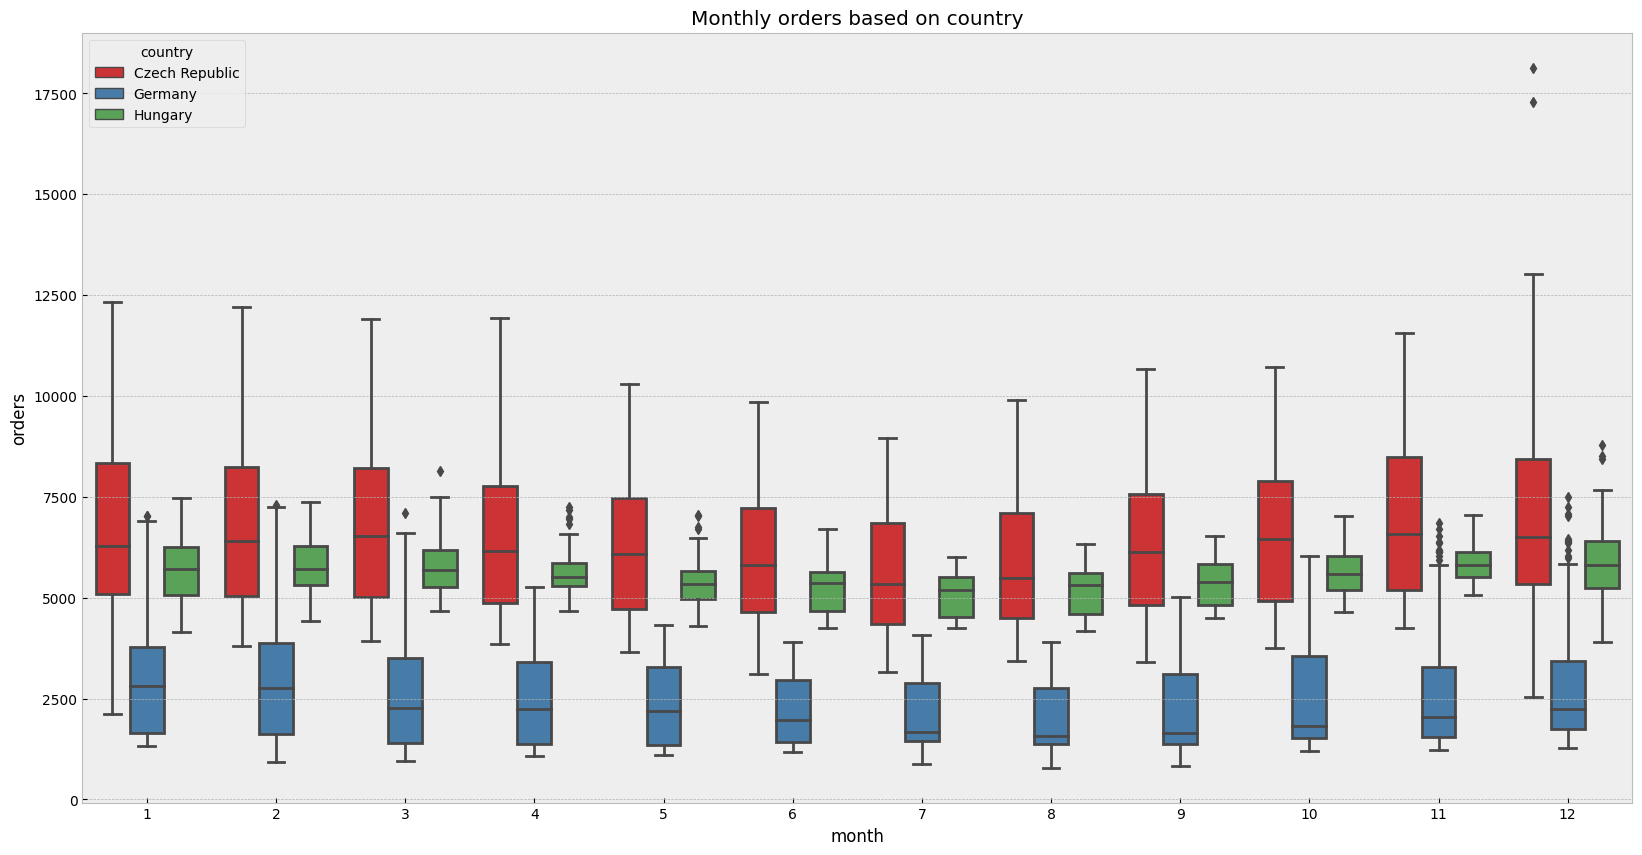

In [30]:
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=train, y='orders', x='month', hue='country', ax=axes, palette='Set1')
handles, _ = axes.get_legend_handles_labels()
axes.set(title='Monthly orders based on country')
plt.show()

# Modeling

In [31]:
# Combine dataframes and create dummies so we have no feature missmatch in the future
combined = pd.concat([train, test], axis=0)
combined = pd.get_dummies(combined)
combined = combined.drop(columns=['date'])

train = combined[~combined['orders'].isnull()]
test = combined[combined['orders'].isnull()]
test = test.drop(columns=['orders'])

In [32]:
# create input and separate target from dataframe
X = train.drop(columns=['orders'])
y = train['orders']

In [33]:
# split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1702)

In [34]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'mape',
    'num_leaves': 15,
    'max_depth': 3,
    'learning_rate': 0.1,
    'metric': {'mape'},
    'verbose': -1
}

In [35]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [36]:
model = lgb.train(params,
                 num_boost_round=3000,
                 train_set=lgb_train,
                 valid_sets=lgb_eval
                 )

In [37]:
y_pred = model.predict(X_val)

In [38]:
print(f'Mean Absolute Percentage Error on Testset: {mean_absolute_percentage_error(y_val, y_pred)}')

Mean Absolute Percentage Error on Testset: 0.04339831859033399


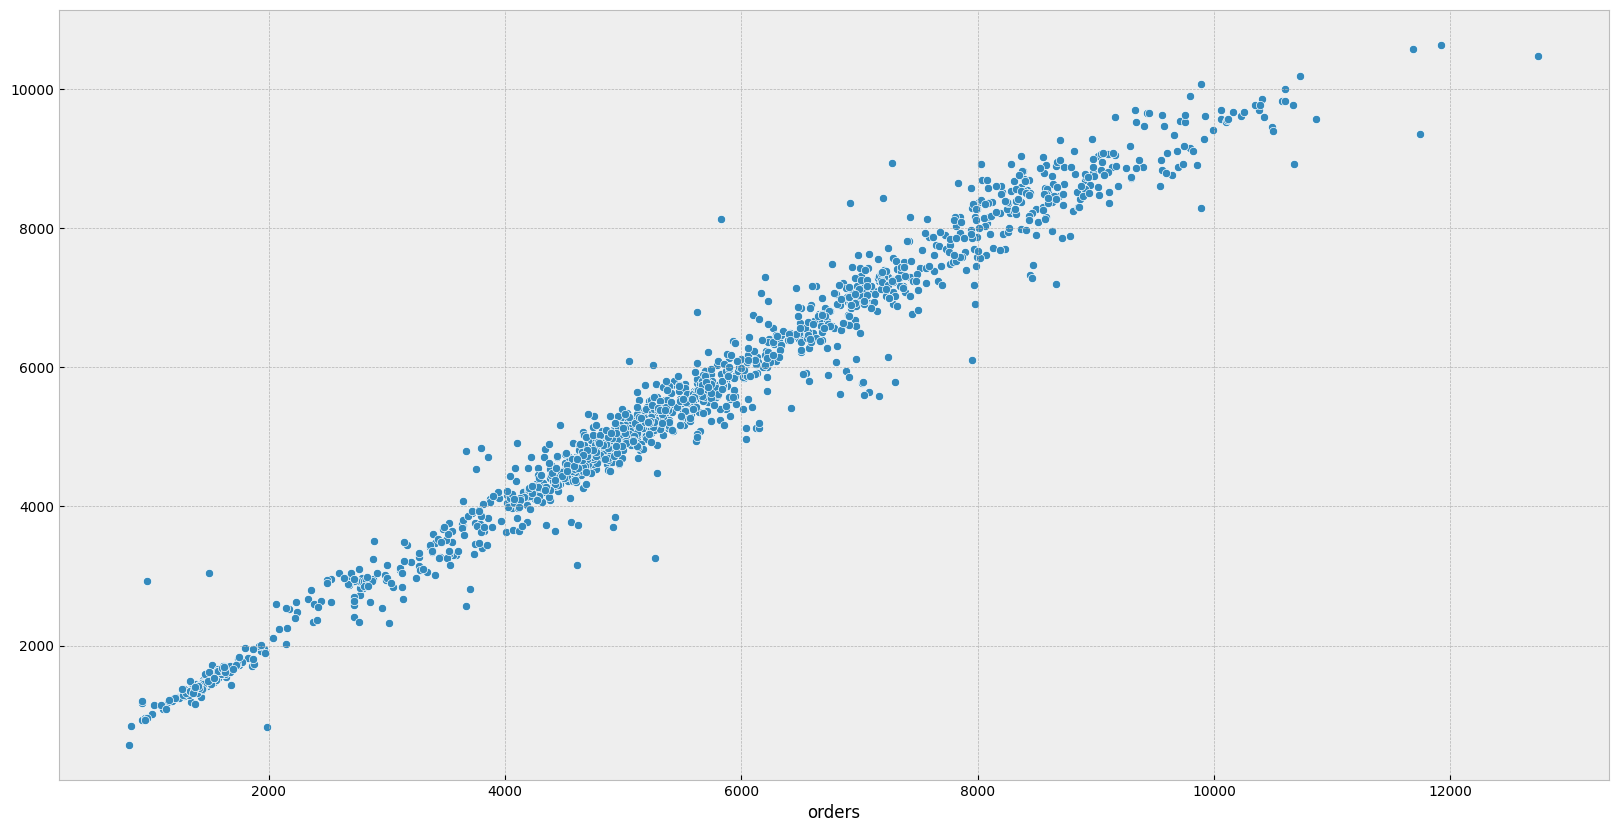

In [39]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=y_val, y=y_pred)
plt.show();

# Prediction and Submission

In [40]:
preds = model.predict(test)

In [41]:
submission = test.copy()
submission['orders'] = preds

In [42]:
sub = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv', index_col='id')
sub['orders'] = preds
sub

,orders
id,
Prague_1_2024-03-16,10160.169833
Prague_1_2024-03-17,9663.186655
Prague_1_2024-03-18,9672.544512
Prague_1_2024-03-19,9545.151835
Prague_1_2024-03-20,9502.640529
...,...
Budapest_1_2024-05-11,6635.980969
Budapest_1_2024-05-12,6295.711720
Budapest_1_2024-05-13,6238.099029


In [43]:
sub[['orders']].to_csv('submission.csv')